In [4]:
import pandas as pd 
import numpy as np 
import glob
import matplotlib.pyplot as plt
from time import time

from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer

# Differnt types of Naive Bayes Classifiers
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB

pd.set_option('display.max_columns', None)

In [7]:
train_path = max(glob.glob('../../train/*.csv'), key=os.path.getctime) 
df = pd.read_csv(train_path)

test_path = max(glob.glob('../../test/*.csv'), key=os.path.getctime) 
test = pd.read_csv(test_path)

In [8]:
test.head()

,reward_tiers,min_reward,max_reward,goal,state,staff_pick,has_video,rewards_0,rewards_1,rewards_2,rewards_3,rewards_4,rewards_5,rewards_6,rewards_7,rewards_8,rewards_9,rewards_10,rewards_11,rewards_12,rewards_13,rewards_14,rewards_15,rewards_16,rewards_17,rewards_18,rewards_19,rewards_20,rewards_21,rewards_22,rewards_23,rewards_24,rewards_25,rewards_26,rewards_27,rewards_28,rewards_29,rewards_30,rewards_31,rewards_32,rewards_33,rewards_34,rewards_35,rewards_36,rewards_37,rewards_38,rewards_39,rewards_40,rewards_41,rewards_42,rewards_43,rewards_44,rewards_45,rewards_46,rewards_47,rewards_48,rewards_49,rewards_50,rewards_51,rewards_52,rewards_53,rewards_54,rewards_55,rewards_56,rewards_57,rewards_58,rewards_59,rewards_60,rewards_61,rewards_62,rewards_63,rewards_64,rewards_65,rewards_66,rewards_67,rewards_68,rewards_69,rewards_70,rewards_71,rewards_72,rewards_73,rewards_74,rewards_75,rewards_76,rewards_77,rewards_78,rewards_79,rewards_80,rewards_81,rewards_82,rewards_83,rewards_84,rewards_85,rewards_86,rewards_87,rewards_88,rewards_89,rewards_90,rewards_91,rewards_92,rewards_93,rewards_94,rewards_95,rewards_96,rewards_97,rewards_98,rewards_99,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,description_10,description_11,description_12,description_13,description_14,description_15,description_16,description_17,description_18,description_19,description_20,description_21,description_22,description_23,description_24,description_25,description_26,description_27,description_28,description_29,description_30,description_31,description_32,description_33,description_34,description_35,description_36,description_37,description_38,description_39,description_40,description_41,description_42,description_43,description_44,description_45,description_46,description_47,description_48,description_49,description_50,description_51,description_52,description_53,description_54,description_55,description_56,description_57,description_58,description_59,description_60,description_61,description_62,description_63,description_64,description_65,description_66,description_67,description_68,description_69,description_70,description_71,description_72,description_73,description_74,description_75,description_76,description_77,description_78,description_79,description_80,description_81,description_82,description_83,description_84,description_85,description_86,description_87,description_88,description_89,description_90,description_91,description_92,description_93,description_94,description_95,description_96,description_97,description_98,description_99,description_story_0,description_story_1,description_story_2,description_story_3,description_story_4,description_story_5,description_story_6,description_story_7,description_story_8,description_story_9,description_story_10,description_story_11,description_story_12,description_story_13,description_story_14,description_story_15,description_story_16,description_story_17,description_story_18,description_story_19,description_story_20,description_story_21,description_story_22,description_story_23,description_story_24,description_story_25,description_story_26,description_story_27,description_story_28,description_story_29,description_story_30,description_story_31,description_story_32,description_story_33,description_story_34,description_story_35,description_story_36,description_story_37,description_story_38,description_story_39,description_story_40,description_story_41,description_story_42,description_story_43,description_story_44,description_story_45,description_story_46,description_story_47,description_story_48,description_story_49,description_story_50,description_story_51,description_story_52,description_story_53,description_story_54,description_story_55,description_story_56,description_story_57,description_story_58,description_story_59,description_story_60,description_story_61,description_story_62,description_story_63,description_story_

## Get to the correct data format

In [9]:
X_train, y_train = df.drop('state', axis=1), df['state']
X_test, y_test = test.drop('state', axis=1), test['state']

In [10]:
train_ohe_cat = X_train.iloc[:, 422:437]
X_train['category'] = train_ohe_cat.idxmax(1)
train_ohe_loc = X_train.iloc[:, 437:-1]
X_train['location'] = train_ohe_loc.idxmax(1)

In [11]:
train_ohe_cat = X_test.iloc[:, 422:437]
X_test['category'] = train_ohe_cat.idxmax(1)
train_ohe_loc = X_test.iloc[:, 437:-1]
X_test['location'] = train_ohe_loc.idxmax(1)

In [12]:
X_train = X_train.drop(X_train.iloc[:, 422:-2].columns, axis=1)
X_test = X_test.drop(X_test.iloc[:, 422:-2].columns, axis=1)

## Mixed NB Approach 1 
convert continuous variables into categorical ones through binning and then train a categorical model

In [13]:
X_train1 = X_train.copy()
X_test1 = X_test.copy()
binary_cols = ['staff_pick', 'has_video']
train_numeric = X_train1.select_dtypes(include='number').drop(binary_cols, axis=1) 
test_numeric = X_test1.select_dtypes(include='number').drop(binary_cols, axis=1) 

In [14]:
for i, col in enumerate(train_numeric.columns):
    X_train1[col], val = pd.qcut(X_train1[col], 5, retbins = True, duplicates = 'drop')
    X_test1[col] = pd.cut(X_test1[col], bins = val, duplicates = 'drop', include_lowest=True)

In [15]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)
X_train1_fitted = enc.fit_transform(X_train1)
X_test1_fitted = enc.transform(X_test1)
imp = SimpleImputer(strategy="most_frequent") # impute nan values
X_train1_fitted = imp.fit_transform(X_train1_fitted)
X_test1_fitted = imp.transform(X_test1_fitted)
model_C = CategoricalNB()
clf_C = model_C.fit(X_train1_fitted, y_train)
y_pred = model_C.predict(X_test1_fitted)

In [16]:
# train classification report
y_train_pred = model_C.predict(X_train1_fitted)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.56      0.69      0.62      7274
           1       0.86      0.77      0.81     17482

    accuracy                           0.75     24756
   macro avg       0.71      0.73      0.72     24756
weighted avg       0.77      0.75      0.76     24756



In [17]:
# test classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.70      0.62      1282
           1       0.86      0.76      0.81      3087

    accuracy                           0.74      4369
   macro avg       0.70      0.73      0.71      4369
weighted avg       0.77      0.74      0.75      4369



In [18]:
print('ROC_AUC: ', roc_auc_score(y_test, y_pred))

ROC_AUC:  0.7311203138115806


## Mixed NB Approach 2

All the implementations of naive bayes are designed specifically to fit a particular type of data or distribution. Since we have three types of data - continuous, binary and categorical, we can train three separate models using continuous, binary and categorical variables. Since naive bayes assumes independence of the features given the class, the final model can then be trained based on predictions from the three models.

In [19]:
X_train2 = X_train.copy()
X_test2 = X_test.copy()
categorical_cols = ['category', 'location']
train_binary = X_train2[binary_cols]
train_categorical = X_train2[categorical_cols]
test_binary = X_test2[binary_cols]
test_categorical = X_test2[categorical_cols]

In [20]:
# ----- Fit three models -----

model_G = GaussianNB()
clf_G = model_G.fit(train_numeric, y_train)

model_C2 = CategoricalNB()
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)
train_categorical = enc.fit_transform(train_categorical)
test_categorical = enc.transform(test_categorical)
imp = SimpleImputer(strategy="most_frequent") 
train_categorical = imp.fit_transform(train_categorical)
test_categorical = imp.transform(test_categorical)
clf_C2 = model_C2.fit(train_categorical, y_train)

model_B = BernoulliNB()
clf_B = model_B.fit(train_binary, y_train)

# ----- Get probability predictions from each model -----
# On training data
G_train_probas = model_G.predict_proba(train_numeric)
C_train_probas = model_C2.predict_proba(train_categorical)
B_train_probas = model_B.predict_proba(train_binary)

# And on testing data
G_test_probas = model_G.predict_proba(test_numeric)
C_test_probas = model_C2.predict_proba(test_categorical)
B_test_probas = model_B.predict_proba(test_binary)

# Combine probability prediction for class=1 from both models
X_new_train = np.c_[(G_train_probas[:,1], C_train_probas[:,1], B_train_probas[:,1])] # Train
X_new_test = np.c_[(G_test_probas[:,1], C_test_probas[:,1], B_test_probas[:,1])] # Test


# ----- Fit Gaussian model on the X_new -----
model = GaussianNB()
clf = model.fit(X_new_train, y_train)
y_pred = model.predict(X_new_test)

In [21]:
# train classification report
y_train_pred = model.predict(X_new_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.63      0.62      0.63      7274
           1       0.84      0.85      0.85     17482

    accuracy                           0.78     24756
   macro avg       0.74      0.73      0.74     24756
weighted avg       0.78      0.78      0.78     24756



In [22]:
# test classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.63      0.63      1282
           1       0.85      0.84      0.84      3087

    accuracy                           0.78      4369
   macro avg       0.73      0.74      0.74      4369
weighted avg       0.78      0.78      0.78      4369



In [23]:
print('ROC_AUC: ', roc_auc_score(y_test, y_pred))

ROC_AUC:  0.7355692964356086


## Hyperparameter Tuning

For approach 1:

In [24]:
param_grid1_nb = {
    'alpha': np.logspace(0,-9, num=100)
}
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

In [25]:
model_grid1 = RandomizedSearchCV(estimator = CategoricalNB(), 
                            param_distributions = param_grid1_nb, 
                            verbose = 1, 
                            cv = cv_method,
                            scoring = 'roc_auc')
model_grid1.fit(X_train1_fitted, y_train)
print('--------------------------------------------------------')
print('Best Estimator: ', model_grid1.best_estimator_)

Fitting 15 folds for each of 10 candidates, totalling 150 fits
--------------------------------------------------------
Best Estimator:  CategoricalNB(alpha=0.0657933224657568)


In [26]:
# train classification report
y_train_pred = model_grid1.predict(X_train1_fitted)
print(classification_report(y_train, y_train_pred, digits=5))

              precision    recall  f1-score   support

           0    0.56003   0.69260   0.61930      7274
           1    0.85812   0.77360   0.81367     17482

    accuracy                        0.74980     24756
   macro avg    0.70907   0.73310   0.71648     24756
weighted avg    0.77053   0.74980   0.75656     24756



In [27]:
# test classification report
y_pred = model_grid1.predict(X_test1_fitted)
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.54969   0.69891   0.61538      1282
           1    0.85907   0.76223   0.80776      3087

    accuracy                        0.74365      4369
   macro avg    0.70438   0.73057   0.71157      4369
weighted avg    0.76829   0.74365   0.75131      4369



In [28]:
print('ROC_AUC: ', roc_auc_score(y_test, y_pred))

ROC_AUC:  0.730568328661232


For approach 2:

In [29]:
param_grid2_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

In [30]:
model_grid2 = RandomizedSearchCV(estimator = GaussianNB(), 
                            param_distributions = param_grid2_nb, 
                            verbose = 1, 
                            cv = cv_method,
                            scoring = 'roc_auc')
model_grid2.fit(X_new_train, y_train)
print('--------------------------------------------------------')
print('Best Estimator: ', model_grid2.best_estimator_)

Fitting 15 folds for each of 10 candidates, totalling 150 fits
--------------------------------------------------------
Best Estimator:  GaussianNB(var_smoothing=0.0015199110829529332)


In [31]:
# train classification report
y_train_pred = model_grid2.predict(X_new_train)
print(classification_report(y_train, y_train_pred, digits=5))

              precision    recall  f1-score   support

           0    0.61648   0.63885   0.62746      7274
           1    0.84743   0.83463   0.84098     17482

    accuracy                        0.77710     24756
   macro avg    0.73195   0.73674   0.73422     24756
weighted avg    0.77957   0.77710   0.77824     24756



In [32]:
# test classification report
y_pred = model_grid2.predict(X_new_test)
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.61128   0.64275   0.62662      1282
           1    0.84839   0.83026   0.83923      3087

    accuracy                        0.77523      4369
   macro avg    0.72984   0.73650   0.73292      4369
weighted avg    0.77882   0.77523   0.77684      4369



In [33]:
print('ROC_AUC: ', roc_auc_score(y_test, y_pred))

ROC_AUC:  0.736500810858479


## Best NB Model
Approach 2 gives a slightly higher ROC_AUC score, with hyperparameter tuning making no significant difference to its performance.

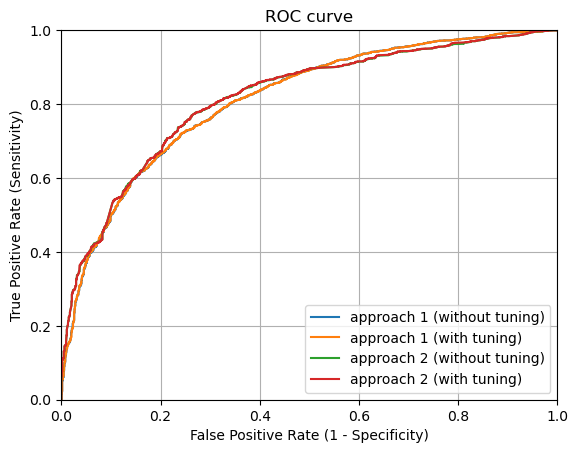

In [34]:
y_pred_prob1 = model_C.predict_proba(X_test1_fitted)[:, 1]
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred_prob1)
y_pred_prob2 = model_grid1.predict_proba(X_test1_fitted)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, y_pred_prob2)
y_pred_prob3 = model.predict_proba(X_new_test)[:, 1]
fpr3, tpr3, thresholds = roc_curve(y_test, y_pred_prob3)
y_pred_prob4 = model_grid2.predict_proba(X_new_test)[:, 1]
fpr4, tpr4, thresholds = roc_curve(y_test, y_pred_prob4)
plt.plot(fpr1, tpr1, label = "approach 1 (without tuning)")
plt.plot(fpr2, tpr2, label ="approach 1 (with tuning)")
plt.plot(fpr3, tpr3, label = "approach 2 (without tuning)")
plt.plot(fpr4, tpr4, label ="approach 2 (with tuning)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid(True)

## Run time

In [35]:
total_time = 0
for i in range(100):
    start_time = time()
    model_time = CategoricalNB(alpha=0.657933224657568)
    clf = model_time.fit(X_train1_fitted, y_train)
    y_pred = model_time.predict(X_test1_fitted)
    run_time = time() - start_time
    total_time += run_time
avg_time = total_time / 100
print("Run time: ", avg_time)

Run time:  0.4698839831352234


In [36]:
total_time = 0
for i in range(100):
    start_time = time()
    model_time2 = GaussianNB(var_smoothing=0.0012328467394420659)
    clf = model_time2.fit(X_new_train, y_train)
    y_pred = model_time2.predict(X_new_test)
    run_time = time() - start_time
    total_time += run_time
avg_time = total_time / 100
print("Run time: ", avg_time)

Run time:  0.006142396926879883


## Feature importance

In [37]:
imps = permutation_importance(model_time, X_test1_fitted, y_test)

In [38]:
imps_sorted = imps.importances_mean.argsort()[::-1]

print(np.take(X_train1.columns, imps_sorted[: 20]))

Index(['rewards_1', 'rewards_0', 'success_rate', 'rewards_3', 'goal',
       'rewards_98', 'rewards_31', 'rewards_99', 'rewards_2', 'rewards_22',
       'funding_duration_in_days', 'rewards_47', 'description_story_16',
       'description_story_47', 'rewards_91', 'rewards_58',
       'description_story_80', 'description_story_85', 'description_story_57',
       'description_story_38'],
      dtype='object')
